Daily gold fixing price (10:30 am London time) in London Bullion Market in US dollars per Troy ounce from January 3, 1995 to November 10, 2016.

In [1]:
import pandas as pd
df = pd.read_csv('Gold.csv')
print(df.head())

         DATE   VALUE
0  1995-01-03  381.40
1  1995-01-04  378.25
2  1995-01-05  375.00
3  1995-01-06  375.90
4  1995-01-09  372.45


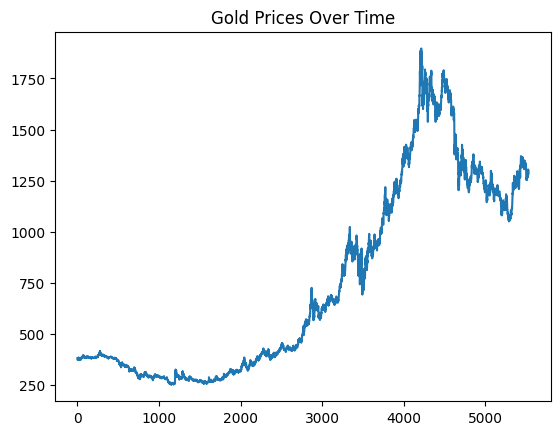

In [ ]:
import matplotlib.pyplot as plt
df['VALUE'].plot(title='Gold Prices Over Time')
plt.show()

In [15]:
# Statistical summary
print(df['VALUE'].describe())

count    5526.000000
mean      745.163409
std       472.874736
min       252.900000
25%       329.737500
50%       499.850000
75%      1197.650000
max      1896.500000
Name: VALUE, dtype: float64


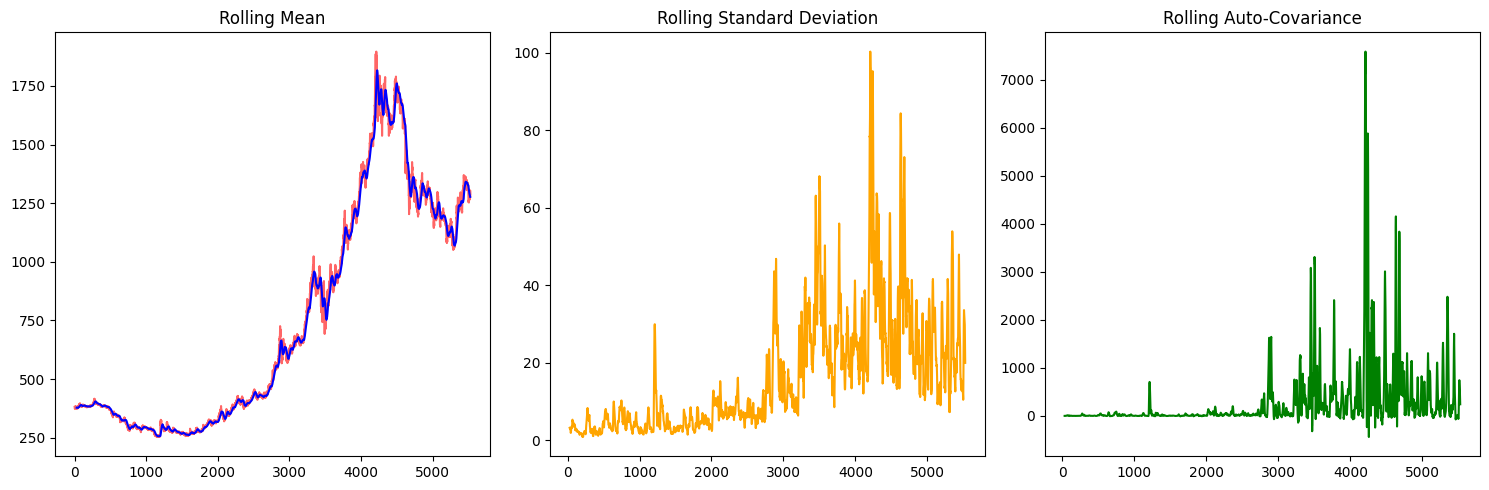

In [ ]:
# rolling mean, rolling std, and rolling autocovariance in subplots
rolling_mean = df['VALUE'].rolling(window=30).mean()
rolling_std = df['VALUE'].rolling(window=30).std()
rolling_cov = df['VALUE'].rolling(window=30).cov(df['VALUE'].shift(5))
fig, axs = plt.subplots(1,3, figsize=(15, 5))
axs[0].plot(df['VALUE'], alpha=0.6, color='red')  
axs[0].plot(rolling_mean, label='Rolling Mean', color='blue')
axs[0].set_title('Rolling Mean')
axs[1].plot(rolling_std, label='Rolling Std', color='orange')
axs[1].set_title('Rolling Standard Deviation')
axs[2].plot(rolling_cov, label='Rolling Auto-Covariance', color='green')
axs[2].set_title('Rolling Auto-Covariance')
plt.tight_layout()

In [32]:
# adf test on original series
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['VALUE'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Value ({}): {:.3f}'.format(key, value))

ADF Statistic: -0.4142315330137865
p-value: 0.9076953665295062
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567


As we can see, the gold prices are non-stationary.
To make the series stationary, we can take the logarithmic returns of the prices.
This will,
1. stabilize the variance
2. remove trends 
This practise is standard in financial time series modelling

<Axes: title={'center': 'Returns Over Time'}>

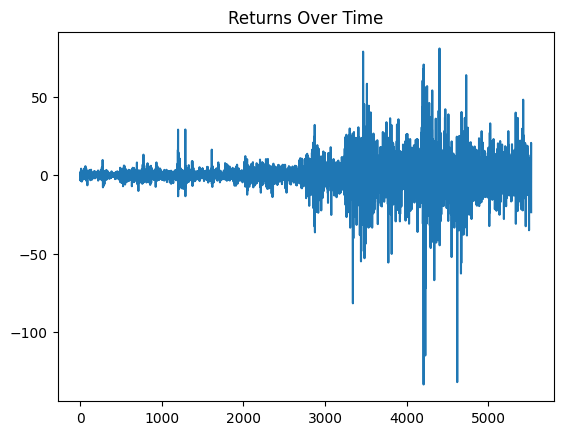

In [35]:
returns = df['VALUE'] - df['VALUE'].shift(1)
returns.plot(title='Returns Over Time')

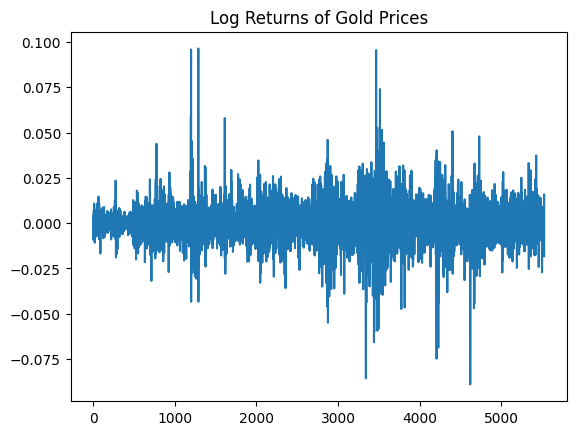

In [3]:
import numpy as np
log_returns = np.log(df['VALUE']) - np.log(df['VALUE']).shift(1)
log_returns.plot(title='Log Returns of Gold Prices')
plt.show()

In [4]:
# test of stationarity
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(log_returns.dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -16.453242337003417
p-value: 2.3675408275407226e-29
Critical Values:
   1%: -3.4315395190228877
   5%: -2.8620656492985126
   10%: -2.567049801950413


Since, the p-value less than 0.05, we can reject the null hypothesis and conclude that the log-returns series is stationary.

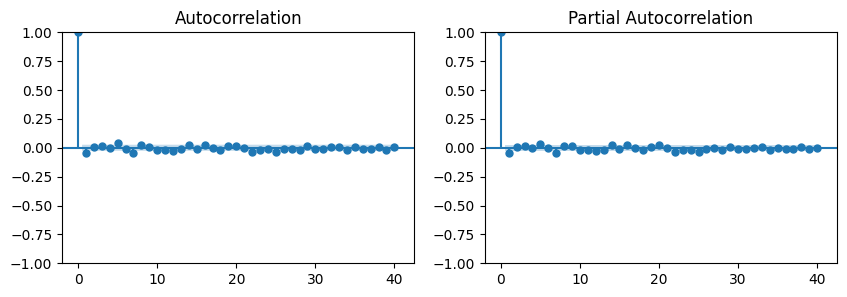

In [34]:
# acf and pacf subplots for log-returns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(10, 3))
plot_acf(log_returns.dropna(), ax=ax[0], lags=40)
plot_pacf(log_returns.dropna(), ax=ax[1], lags=40)
plt.show()

As we can see, both the acf and pacf plots cut off at 0. This indicates that this is a white noise series with no significant autocorrelations. This implies ARMA(0, 0). \
GARCH can be used here to model the variance.

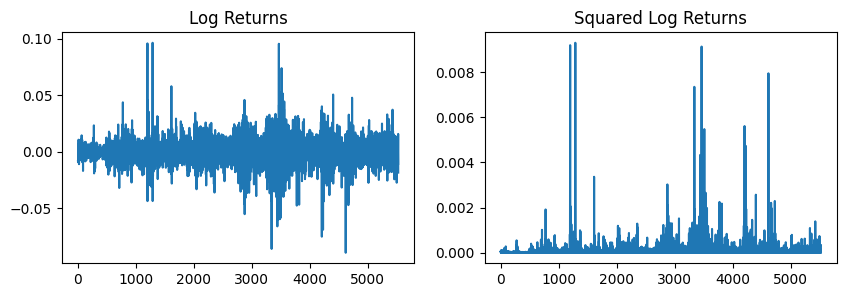

In [6]:
# sub-plots of log-returns and its squared values
fig, ax = plt.subplots(1,2, figsize=(10, 3))
log_returns.dropna().plot(ax=ax[0], title='Log Returns')
(log_returns.dropna()**2).plot(ax=ax[1], title='Squared Log Returns')
plt.show()

The squared returns show significant volatility clustering followed by tranquil periods. \
This suggests time-varying conditional variance and motivates the use of GARCH models.

In [7]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(log_returns.dropna())
print("ARCH LM statistic:", arch_test[0])
print("ARCH LM p-value:", arch_test[1])

ARCH LM statistic: 363.2142145682411
ARCH LM p-value: 6.236969342401675e-72


The ARCH-LM test statistic strongly rejects the null hypothesis of no ARCH effects (p-value < 0.05), indicating the presence of ARCH effects in the log-returns series.

In [8]:
from arch import arch_model

garch = arch_model(
    log_returns.dropna()*100,
    mean='Zero',
    vol='GARCH',
    p=1,
    q=1,
    dist='t'
)

garch_res = garch.fit(update_freq=10)
print(garch_res.summary())

Iteration:     10,   Func. Count:     59,   Neg. LLF: 7196.840734643902
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7196.839098281343
            Iterations: 18
            Function evaluations: 106
            Gradient evaluations: 16
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                        VALUE   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -7196.84
Distribution:      Standardized Student's t   AIC:                           14401.7
Method:                  Maximum Likelihood   BIC:                           14428.1
                                              No. Observations:                 5525
Date:                      Sun, Jan 18 2026   Df Residuals:                     5525
Time:                              06:

In [9]:
std_resid = garch_res.std_resid

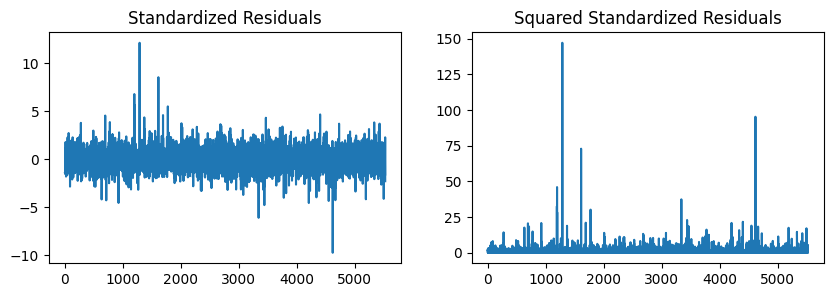

In [10]:
# subplots of standardized residuals and squared standardized residuals
fig, ax = plt.subplots(1,2, figsize=(10, 3))
std_resid.plot(ax=ax[0], title='Standardized Residuals')
(std_resid**2).plot(ax=ax[1], title='Squared Standardized Residuals')
plt.show()

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_resid = acorr_ljungbox(std_resid, lags=[10], return_df=True)
lb_sq = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)

print("LB on residuals:\n", lb_resid)
print("\nLB on squared residuals:\n", lb_sq)

LB on residuals:
       lb_stat  lb_pvalue
10  13.407149    0.20179

LB on squared residuals:
      lb_stat  lb_pvalue
10  8.922736   0.539452


If L-box p-value > 0.05 for residuals, no remaining autocorrelation in mean. \
If L-box p-value > 0.05 for squared residuals, GARCH model adequately captures volatility clustering.

In [12]:
arch_post = het_arch(std_resid)
print("ARCH p-value after GARCH:", arch_post[1])

ARCH p-value after GARCH: 0.5439505292998625


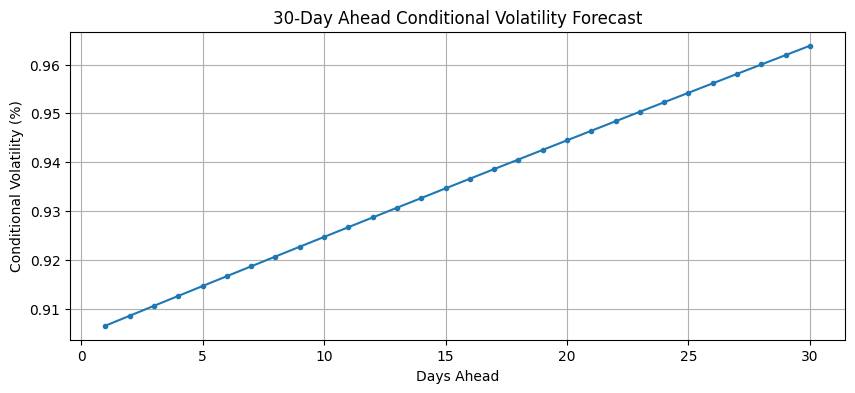

In [13]:
forecast = garch_res.forecast(horizon=30)


variance_forecast = forecast.variance.iloc[-1]
volatility_forecast = np.sqrt(variance_forecast)

plt.figure(figsize=(10, 4))
plt.plot(range(1, 31), volatility_forecast.values, marker='o', markersize=3)
plt.xlabel('Days Ahead')
plt.ylabel('Conditional Volatility (%)')
plt.title('30-Day Ahead Conditional Volatility Forecast')
plt.grid(True)
plt.show()

Volatility is expected to increase gradually over the next month and then stabilize